# Transfer Learning

### Aufgabe
_Wählen Sie nun 5 andere Hunderassen aus. Nutzen Sie Transfer Learning zur Klassifikation dieser
Rassen, d.h. laden Sie die Gewichte aus Ihrem in Teilaufgabe B5 trainierten Modell als initiale
Gewichte für das neue Training. Beschreiben Sie ihr Vorgehen im Kurzreport und setzen Sie die
Evaluation dieses erneuten Trainings in Relation zu den Evaluationsergebnissen ihres ursprünglichen
Modells._

In [1]:
import keras
import tensorflow as tf
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

%matplotlib inline

notebook_dir = Path().resolve()
sys.path.append(str(notebook_dir.parent))

from utils.setup import setup_dataset, generateDatasetArrays
from helper.visualize import visualize_history, visualize_predictions, getDognames

# load configuration
import config as Config

# config overrides
Config.DOG_LABEL_IDS = [42, 23, 85, 99, 12] # 5 andere Hunderassen

2024-12-14 01:19:21.195852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734135561.206135 1345609 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734135561.209263 1345609 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-14 01:19:21.221066: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_dataset, test_dataset, label_lookup_table, info = setup_dataset('../dataset', labels=Config.DOG_LABEL_IDS)

def preprocess(data):
    data["original_image"] = tf.identity(data["image"])
    data["image"] = tf.image.resize(data["image"], Config.RESIZE_SIZE)
    data["label"] = label_lookup_table.lookup(data["label"])
    return data

train_dataset = (
    train_dataset
        .map(preprocess)
        .shuffle(1000)
        .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    test_dataset
        .map(preprocess)
        .shuffle(100)
        .prefetch(tf.data.AUTOTUNE)
)

I0000 00:00:1734135563.131758 1345609 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8691 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:08:00.0, compute capability: 8.6


In [3]:
model = keras.models.load_model(os.path.join(Config.MODEL_FOLDER, Config.MODEL_FILENAME))

model.pop()
model.pop()
model.pop()

model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5, name="dense_dropout"))
model.add(keras.layers.Dense(Config.NUM_CLASSES, activation='softmax'))

# Freeze the layers except the last three
for layer in model.layers[:-3]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.9057 - loss: 0.5404 - val_accuracy: 0.3905 - val_loss: 5.4250
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9539 - loss: 0.2096 - val_accuracy: 0.3429 - val_loss: 5.3979
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9925 - loss: 0.0114 - val_accuracy: 0.3333 - val_loss: 5.5536
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9302 - loss: 0.2390 - val_accuracy: 0.3048 - val_loss: 5.6865
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9734 - loss: 0.1500 - val_accuracy: 0.3048 - val_loss: 5.7713
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9962 - loss: 0.0132 - val_accuracy: 0.3048 - val_loss: 5.8416
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9334 - loss: 0.2721 - val_accuracy: 0.2952 - val_loss: 5.8749
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9804 - loss: 0.0857 - val_accuracy: 0.3333 - val_loss: 5.9292


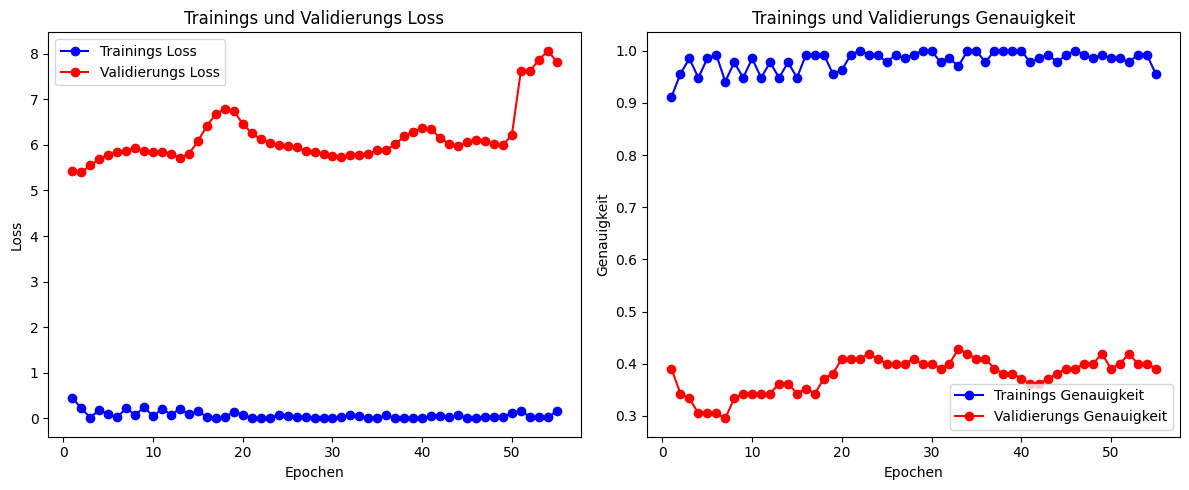

In [6]:
images, labels = generateDatasetArrays(train_dataset)
images_test, labels_test = generateDatasetArrays(test_dataset)

history = model.fit(
    images, labels,
    validation_data=(images_test, labels_test),
    epochs=50,
    batch_size=Config.BATCH_SIZE,
    verbose=1 if Config.DEBUG else 0
)

# Feinabstimmung des gesamten Modells
for layer in model.layers:
    layer.trainable = True  # Alle Schichten freigeben

# Reduzierte Lernrate für Fine-Tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
print("Finetuning des gesamten Modells")
history_finetune = model.fit(
    images, labels,
    validation_data=(images_test, labels_test),
    epochs=5,
    batch_size=16,
    verbose=1 if Config.DEBUG else 0
)

history_finetune = model.fit(
    images, labels,
    validation_data=(images_test, labels_test),
    epochs=5,
    batch_size=16,
    verbose=1 if Config.DEBUG else 0
)

loss, acc = model.evaluate(images_test, labels_test, verbose=0)
print('Test accuracy: %.3f' % acc) 

# Kombinieren der Trainingsergebnisse, damit das Trainieren der letzten Ebenenen, sowie das Feintuning in einem Graph visualisiert wird
for key in history.history.keys():
    history.history[key].extend(history_finetune.history[key])

visualize_history(history.history)

model.save(os.path.join(Config.MODEL_FOLDER, Config.TRANSFER_MODEL_FILENAME))

Model loaded successfully!


2024-12-14 01:21:19.284718: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


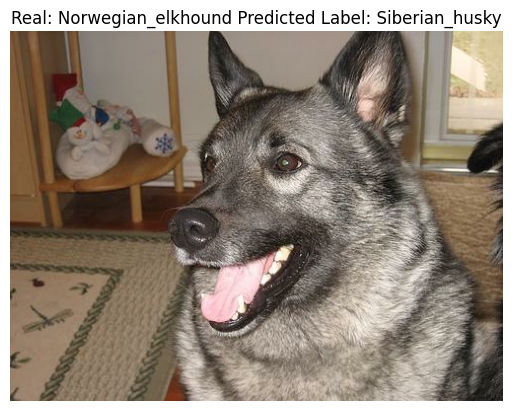

tf.Tensor(b'Images/n02091467-Norwegian_elkhound/n02091467_708.jpg', shape=(), dtype=string)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


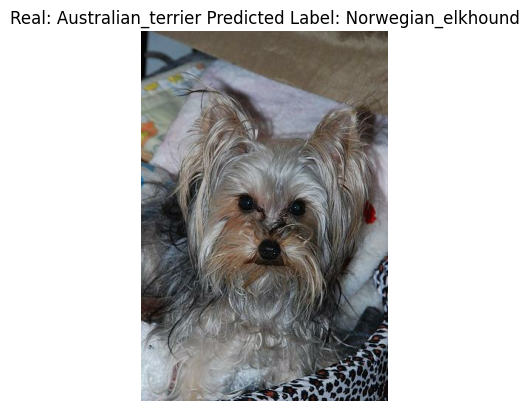

tf.Tensor(b'Images/n02096294-Australian_terrier/n02096294_6988.jpg', shape=(), dtype=string)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


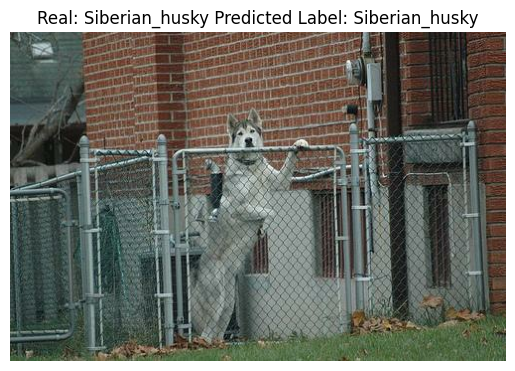

tf.Tensor(b'Images/n02110185-Siberian_husky/n02110185_7413.jpg', shape=(), dtype=string)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


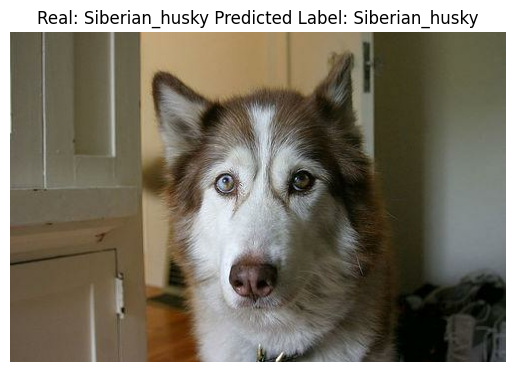

tf.Tensor(b'Images/n02110185-Siberian_husky/n02110185_1614.jpg', shape=(), dtype=string)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


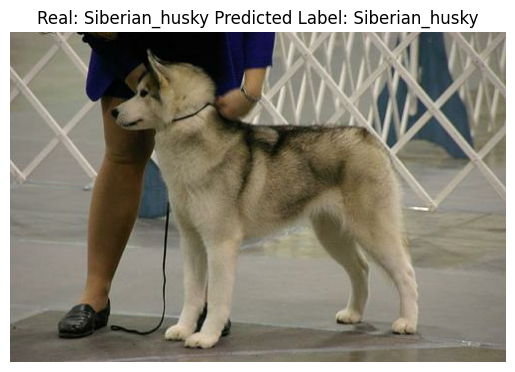

tf.Tensor(b'Images/n02110185-Siberian_husky/n02110185_7936.jpg', shape=(), dtype=string)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


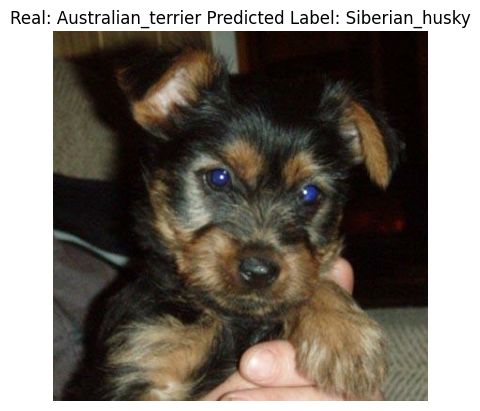

tf.Tensor(b'Images/n02096294-Australian_terrier/n02096294_3866.jpg', shape=(), dtype=string)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


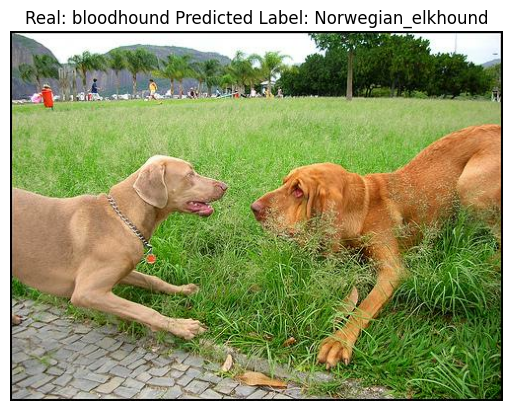

tf.Tensor(b'Images/n02088466-bloodhound/n02088466_7731.jpg', shape=(), dtype=string)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


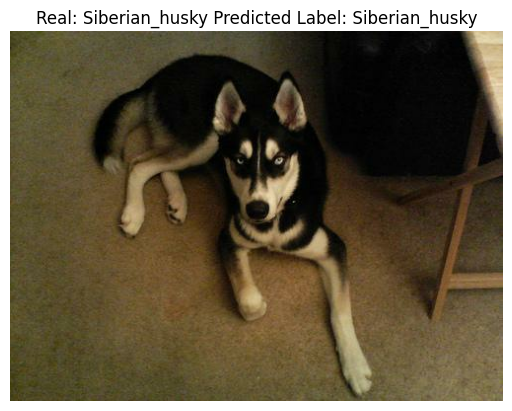

tf.Tensor(b'Images/n02110185-Siberian_husky/n02110185_725.jpg', shape=(), dtype=string)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


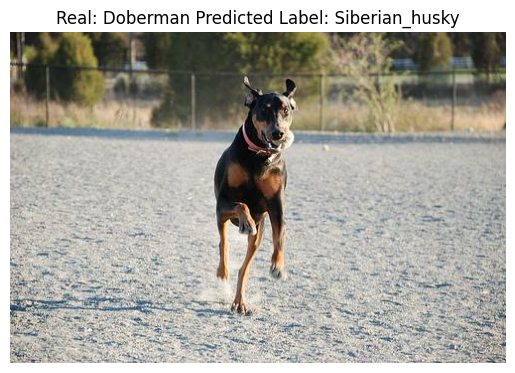

tf.Tensor(b'Images/n02107142-Doberman/n02107142_788.jpg', shape=(), dtype=string)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


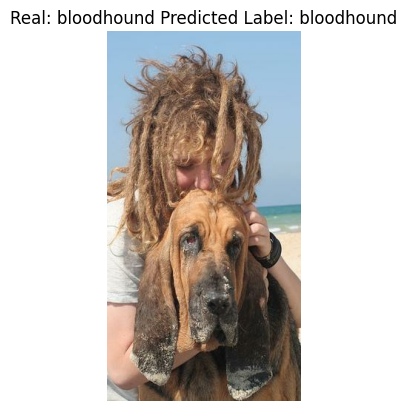

tf.Tensor(b'Images/n02088466-bloodhound/n02088466_7048.jpg', shape=(), dtype=string)


In [7]:
visualize_predictions(
    os.path.join(Config.MODEL_FOLDER, Config.TRANSFER_MODEL_FILENAME),
    test_dataset
)